This notebook shows how to run 4D example of DIVA.<br>
The input files and the figures are created within the notebook.

In [1]:
import os
import logging
import shutil
import subprocess

In [9]:
from divafunctions import make_diva2D_filenames

ModuleNotFoundError: No module named 'diva2D'

# Setup 

Adapt the path to the diva installation you want to work with.

In [2]:
divadir = "/home/ctroupin/Software/DIVA/diva-4.7.1"

## Logging configuration

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Create a function to generate the paths to the main directories, based on the location of the main DIVA directory.

In [6]:
def make_diva_directories(divadir):
    '''Create directory names based on the Diva main directory.'''
    if os.path.isdir(divadir):
        logging.debug("{0} already exists".format(divadir))
        divabindir = os.path.join(divadir, 'DIVA3D/bin') 
        divasrcdir = os.path.join(divadir, 'DIVA3D/src/Fortan')
        diva2Ddir = os.path.join(divadir, 'DIVA3D/divastripped')
        diva4Ddir = os.path.join(divadir, 'JRA4/Climatology')
        return divabindir, divasrcdir, diva2Ddir, diva4Ddir
    else:
        logging.error("%{0} is not a directory".format(divadir))
        return '', '', '', ''

In [7]:
divabindir, divasrcdir, diva2Ddir, diva4Ddir = make_diva_directories(divadir)

DEBUG:root:/home/ctroupin/Software/DIVA/diva-4.7.1 already exists


We also need to create the path to the main input files, to which the parameters will be written.

In [ ]:
def make_diva_input(diva2Ddir):
    '''Generate the input file names and location based on the diva2D main directory.'''
    ContourFile = os.path.join(diva2Ddir, 'input/coast.cont')
    ParameterFile = os.path.join(diva2Ddir, 'input/param.par')
    DataFile = os.path.join(diva2Ddir, 'input/data.dat')
    ValatxyFile = os.path.join(diva2Ddir, 'input/valatxy.coord')
    return ContourFile, DataFile, ParameterFile, ValatxyFile

In [180]:
ContourFile, DataFile, ParameterFile, ValatxyFile = make_diva_input(diva2Ddir)

# Prepate the input files

## Contour

Create a sequence of points representing the contour (no crossing, no duplicate points, etc).<br>
It is defined as a list of list of tuples (don't forget the double brackets!).

In [198]:
contours = [[(0., 0.), (2., 0.), (2., 4.), (0., 4.)], 
           [(2.5, 0.), (6., 0.), (6., 3.), (2.5, 3.)]
           ]

In [199]:
def write_contour(contours, ContourFile):
    ncontours = len(contours)
    logger.debug("Contour has {0} sub-contours".format(ncontours))
    with open(ContourFile, 'w') as f:
        f.write(str(ncontours) + '\n')
        for n, contour in enumerate(contours):
            npoints = len(contour)
            logger.debug("Sub-contour no. {0} has {1} points".format(n, npoints))
            f.write(str(npoints) + '\n')
            for points in contour:
                line = ' '.join(str(x) for x in points)
                f.write(line + '\n')

In [200]:
write_contour(contours, ContourFile)

DEBUG:root:Contour has 2 sub-contours
DEBUG:root:Sub-contour no. 0 has 4 points
DEBUG:root:Sub-contour no. 1 has 4 points


## Data

Create a sequence of coordinates and values representing the data points. <br>
It is defined as a list of tuples, each tuple containing 3 or 4 values (if weights are also included).<br>
It is not a problem to mix 3- and 4-value tuples, as diva can deal with such kind of data file.=+

In [185]:
data = [(1.2, 2.1, 1., 1.), (2., 3.5, -2), (3., 2., 4), (5.5, 0.2, -1)]

In [186]:
def write_data(data, DataFile):
    ndata = len(data)
    with open(DataFile, 'w') as f:
        for datapoints in data:
            line = ' '.join(str(x) for x in datapoints)
            f.write(line + '\n')     

In [187]:
write_data(data, DataFile)

## Parameters

In [188]:
xmin, ymin, nx, ny, dx, dy = 0.0, 0.0, 61, 81, 0.1, 0.05

In [189]:
CorrelationLength = 1.5
SignalToNoiseRatio = 0.5
VarianceBackgroundField = 1.0
ExclusionValue = -999.
iCoordChange = 0
iSpec = 11
iReg = 0

In [192]:
def write_parameter(CorrelationLength, iCoordChange, iSpec, iReg,
                    xmin, ymin, dx, dy, nx, ny,
                    ExclusionValue, SignalToNoiseRatio, VarianceBackgroundField, ParameterFile):

    ParamString = ("# Correlation Length lc \n{0} \n"
            "# icoordchange \n{1} \n"
            "# ispec \n{2} \n"
            "# ireg \n{3} \n"
            "# xori \n{4} \n"
            "# yori \n{5} \n"
            "# dx \n{6} \n"
            "# dy \n{7} \n"
            "# nx \n{8} \n"
            "# ny \n{9} \n"
            "# valex \n{10} \n"
            "# snr \n{11} \n"
            "# varbak \n{12}".format(CorrelationLength, iCoordChange, iSpec, iReg,
                                     xmin, ymin, dx, dy, nx, ny,
                                     ExclusionValue, SignalToNoiseRatio, VarianceBackgroundField)
           )
    with open(ParameterFile, 'w') as f:
        f.write(ParamString)

In [193]:
write_parameter(CorrelationLength, iCoordChange, iSpec, iReg, xmin, ymin, dx, dy, nx, ny,
                ExclusionValue, SignalToNoiseRatio, VarianceBackgroundField, ParameterFile)

# Run diva

## Mesh generation

In [201]:
logging.info("Generating finite element mesh")
subprocess.Popen("./divamesh", cwd=diva2Ddir, shell=True)

INFO:root:Generating finite element mesh


## Run the diva calculation

In [202]:
logging.info("Generating gridded field")
subprocess.Popen("./divacalc", cwd=diva2Ddir, shell=True)

INFO:root:Generating gridded field


# Time for some plots

In [203]:
import netCDF4
import matplotlib.pyplot as plt

## Results 

In [204]:
with netCDF4.Dataset(os.path.join(diva2Ddir, 'output/ghertonetcdf/results.nc')) as nc:
    x = nc.variables['x'][:]
    y = nc.variables['y'][:]
    field = nc.variables['analyzed_field'][:]
    try:
        error = nc.variables['errer_field'][:]
    except KeyError:
        logger.warning('No error field stored in the file')

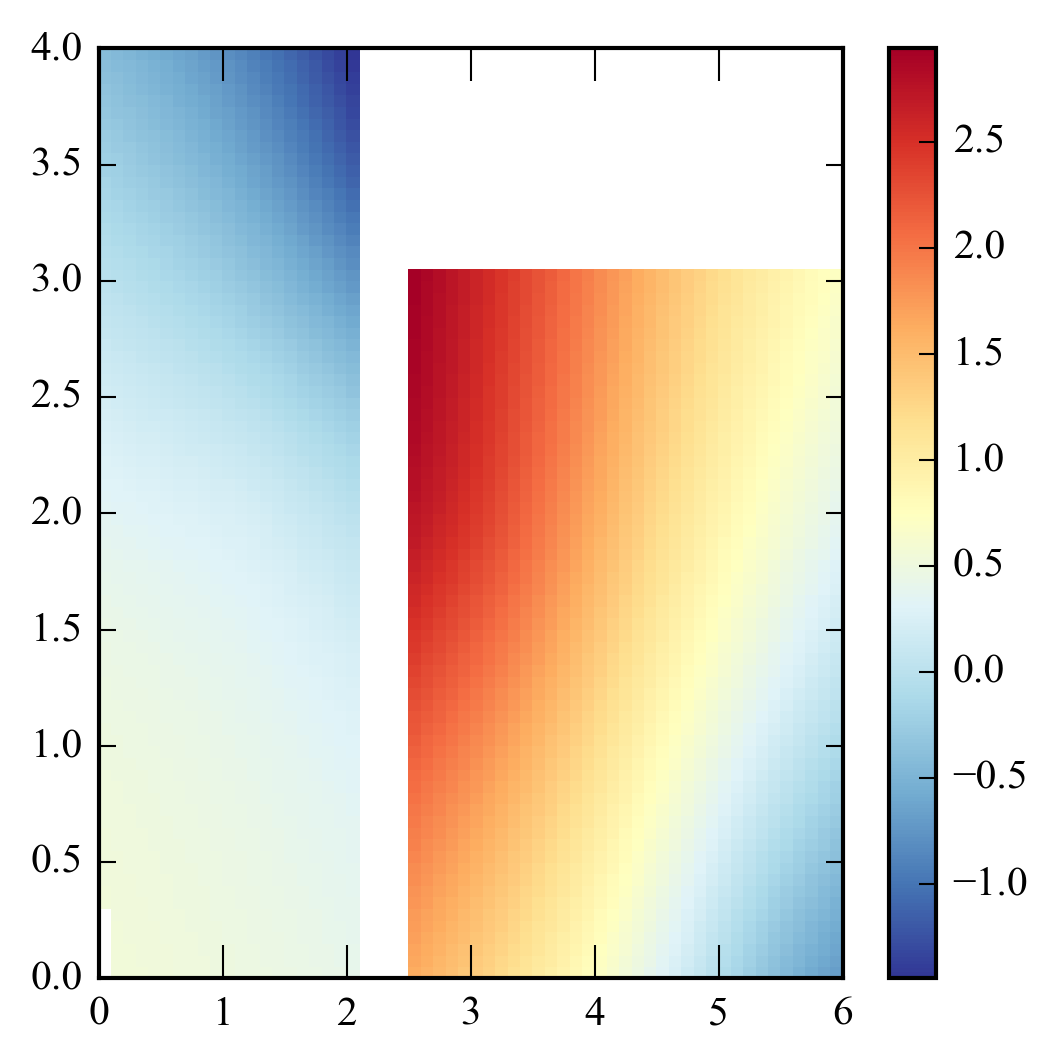

In [205]:
cmap = plt.cm.RdYlBu_r
fig = plt.figure(figsize=(4, 4))
pcm = plt.pcolormesh(x, y, field, cmap=cmap)
cbar = plt.colorbar(pcm)
plt.show()